<a href="https://colab.research.google.com/github/yj336/Image-classification/blob/master/Image_Classification_Proejct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <font size="4">CIFAR100 Image Classification</font><br>



In [0]:

from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation

from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

### Data preparation
1) Data first loaded from external site and label preparation

In [0]:
def PreprocessDataset():
    (x_train_org, y_train_org), (x_test_org, y_test_org) = cifar100.load_data(label_mode='fine')
    x_train_org = x_train_org.astype('float32')
    x_test_org = x_test_org.astype('float32')
    # Normalize value to [0, 1]
    x_train_org /= 255
    x_test_org /= 255
    # Transform lables to one-hot
    y_train_org = np_utils.to_categorical(y_train_org, 100)
    y_test_org = np_utils.to_categorical(y_test_org, 100)
    # Reshape: here x_train is re-shaped to [channel] × [width] × [height]
    # In other environment, the orders could be different; e.g., [height] × [width] × [channel].
    x_train_org = x_train_org.reshape(x_train_org.shape[0], 32, 32, 3)
    x_test_org = x_test_org.reshape(x_test_org.shape[0], 32, 32, 3)
    return [x_train_org, x_test_org, y_train_org, y_test_org]
x_train_org, x_test_org, y_train_org, y_test_org = PreprocessDataset()

CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

#Label chose:
label_choosen = ['bridge', 'castle', 'house', 'road', 'skyscraper','cloud', 'forest', 'mountain', 'plain','sea']
label_loc = []
for item in CIFAR100_LABELS_LIST:
  if item in label_choosen:
    print([CIFAR100_LABELS_LIST.index(item), item])
    label_loc.append(CIFAR100_LABELS_LIST.index(item))

[12, 'bridge']
[17, 'castle']
[23, 'cloud']
[33, 'forest']
[37, 'house']
[49, 'mountain']
[60, 'plain']
[68, 'road']
[71, 'sea']
[76, 'skyscraper']


2) Combine testing and training data into one after you load the cifar100 data


In [0]:
def concat(train,test):
  res = np.concatenate((train,test), axis = 0)
  print ('Shape:', res.shape)
  return res
x = concat(x_train_org,x_test_org)
y = concat(y_train_org,y_test_org)

Shape: (60000, 32, 32, 3)
Shape: (60000, 100)


3) Filter to select images belonging to your assigned superclasses and make it ready to use

In [0]:
#set up subclass
def subclass(x, y):
  x_dict = {}
  y_dict = {}
  for i, item in enumerate(y):
    if np.argmax(item) in label_loc:
      if np.argmax(item) in x_dict.keys():
        x_dict[np.argmax(item)].append(x[i])
        y_dict[np.argmax(item)].append(y[i])
      else:
        x_dict[np.argmax(item)] = []
        x_dict[np.argmax(item)].append(x[i])
        y_dict[np.argmax(item)] = []
        y_dict[np.argmax(item)].append(y[i])
  return x_dict, y_dict

x_dict,y_dict = subclass(x, y)
#x_train_dict, y_train_dict = subclass(x_train_org, y_train_org)
#x_test_dict, y_test_dict = subclass(x_test_org, y_test_org)

# return np.array
binary_label_loc_0 = [12,17,37,68,76]
#binary_label_loc_test_0 = [37]
binary_label_loc_1 = [23,33,49,60,71]
#binary_label_loc_test_1 = [60]

def subclass_np(x_dict, y_dict, labels):
  x = []
  y= []
  for key in labels:
    x.append(x_dict[key])
    y.append(y_dict[key])
  x = np.array(x)
  x = x.reshape(x.shape[0]*x.shape[1], 32,32,3)
  y = np.array(y)
  y =  y.reshape(y.shape[0]*y.shape[1], 100,1)
  return x,y

x_0, y_0 = subclass_np(x_dict,y_dict,binary_label_loc_0)
#x_test_0,y_test_0 =    subclass_np(x_dict,y_dict,binary_label_loc_test_0)
x_1, y_1 = subclass_np(x_dict,y_dict, binary_label_loc_1)
#x_test_1, y_test_1 =   subclass_np(x_dict,y_dict, binary_label_loc_test_1)

In [0]:
#x_train = np.concatenate((x_train_0,x_train_1), axis = 0)
#x_test = np.concatenate((x_test_0,x_test_1),axis = 0)
#y_train_0 = np.zeros(x_train_0.shape[0])
#y_train_1 = np.ones(x_train_1.shape[0])
#y_test_0 = np.zeros(x_test_0.shape[0])
#y_test_1 = np.ones(x_test_1.shape[0])

#x = np.concatenate((x_0,x_1), axis = 0)


y_0 = np.zeros(x_0.shape[0])
y_1 = np.ones(x_1.shape[0])
y = np.concatenate((y_0,y_1), axis = 0)

#x = x.reshape(x.shape[0], 32*32*3)
x_0.shape

(3000, 32, 32, 3)

**Image printing function definition** 

In [0]:
#Print img
def img_print(y_test, y_test_pred, model):
  index = [np.random.choice(range(len(y_test))) for i in range(6)]
  fig = plt.figure(figsize=(5, 5))
  fig.suptitle('Randomly selected pictures from %s'%model)
  n = 0
  for j in range(3):
    for k in range(2):
      i_inds = (j*2)+k
      i_data = index[n]
      ax = fig.add_subplot(2,3, i_inds+1)
      ax.imshow(x_test[i_data].reshape(32,32,3).astype(float), interpolation='nearest')
      label = "ManMade" if y_test_pred[i_data] == 0 else "Natural"
      if y_test[i_data] != y_test_pred[i_data]:
        ax.set_title(label, color = 'red')
      else:
        ax.set_title(label)  
      plt.axis('off')
      n+=1
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

###Prediction  
1)Design your ML algorithm to predict this binary classification problem.

2) Show your prediction score with train-test-split

3) List 36 random images with original and predicted labels

4) Use confusion matrix and classificaton report to analyze your binary classificaton result

5) Explain your result with annotated screenshots in your report

6) Report any lesson learned and how you improve your work.



#Extract "house" & "plain" as testing data and the rest in "man made" & "nature" as training data

In [0]:
x_0 = x_0.reshape(3000,32*32*3)
x_1 = x_1.reshape(3000,32*32*3)
    #x_0 = x_0.reshape(3000,32*32*3)
i = 2
x_train_0 = np.concatenate((x_0[:i*600],x_0[(i+1)*600:]), axis = 0)
x_test_0 = x_0[i*600:(i+1)*600]


y_train_0 = np.zeros(x_train_0.shape[0])
y_test_0 = np.zeros(x_test_0.shape[0])

#print([y_train_0.shape,y_test_0.shape])
j = 3
#x_1 = x_1.reshape(3000,32*32*3)
x_train_1 = np.concatenate((x_1[:j*600],x_1[(j+1)*600:]), axis = 0)
x_test_1 = x_1[j*600:(j+1)*600]

y_train_1 = np.ones(x_train_1.shape[0])
y_test_1 = np.ones(x_test_1.shape[0])

x_train = np.concatenate((x_train_0,x_train_1), axis = 0)     
x_test = np.concatenate((x_test_0,x_test_1), axis = 0)
y_train = np.concatenate((y_train_0,y_train_1), axis =0)
y_test = np.concatenate((y_test_0,y_test_1), axis = 0)
      

**Apply random forest model **

In [0]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
y_test_pred = clf.predict(x_test)
print ("Random Forest Train: {}%".format(clf.score(x_train, y_train)*100))
print ("Random Forest Test: {}%".format(clf.score(x_test, y_test)*100))

Random Forest Train: 100.0%
Random Forest Test: 60.25%


In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67       600
         1.0       0.67      0.41      0.51       600

   micro avg       0.60      0.60      0.60      1200
   macro avg       0.62      0.60      0.59      1200
weighted avg       0.62      0.60      0.59      1200

        pred:0  pred:1
true:0     477     123
true:1     354     246


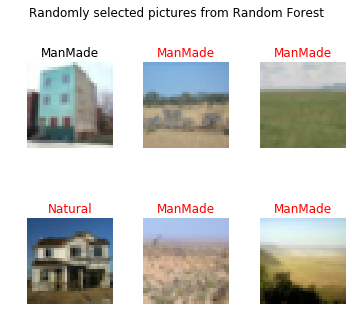

In [0]:
img_print(y_test, y_test_pred, 'Random Forest')

**Apply BaggingClassifier model **

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [0]:

clf = BaggingClassifier(base_estimator= RandomForestClassifier(n_estimators = 100)
                         ,max_samples=0.5,max_features=0.5).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)



In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.56      0.75      0.64       600
         1.0       0.62      0.41      0.49       600

   micro avg       0.58      0.58      0.58      1200
   macro avg       0.59      0.58      0.56      1200
weighted avg       0.59      0.58      0.56      1200

        pred:0  pred:1
true:0     448     152
true:1     356     244


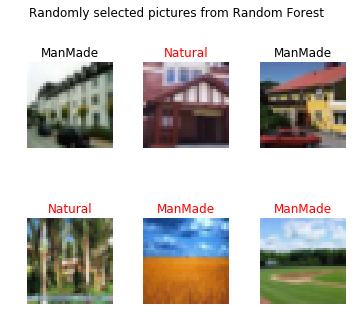

In [0]:
img_print(y_test, y_test_pred, 'BaggingClassifier')

**Apply svc model**

In [0]:
sv = SVC(C=5000, gamma=0.001, kernel='rbf')
sv.fit(x_train, y_train)
y_test_pred = sv.predict(x_test)
print ("SVM from gridsearch Train: {}%".format(sv.score(x_train, y_train)*100))
print ("SVM from gridsearch Test: {}%".format(sv.score(x_test, y_test)*100))

SVM from gridsearch Train: 100.0%
SVM from gridsearch Test: 64.25%


In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.62      0.75      0.68       600
         1.0       0.68      0.54      0.60       600

   micro avg       0.64      0.64      0.64      1200
   macro avg       0.65      0.64      0.64      1200
weighted avg       0.65      0.64      0.64      1200

        pred:0  pred:1
true:0     448     152
true:1     277     323


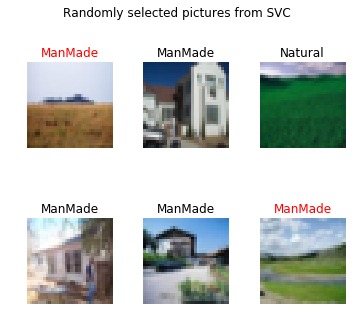

In [0]:
img_print(y_test, y_test_pred, 'SVC')

#If you do not want to use Feature Extraction, please use the following code to run 25 models at one time


All the useful results are stored in model_ dictionaries. 

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def grid_model_fitting(x_0,x_1, model):
  # 5 labels 0, 5 labels 1
  # x[:3000] labels 0; x[3000:] labels 1
  # for i in range(5):
  #    x_0[i*600:(i+1)*600] as testing data 0
  #.   for j in range(5):
  #.       x_1[j*600:(j+1)*600] as testing data 1
  model_results = {}
  model_report = {}
  model_y_pred = {}
  model_matrix = {}
  model_scores = {}
  #worst_model_results = {}
  n = 0
  x_0 = x_0.reshape(3000,32*32*3)
  x_1 = x_1.reshape(3000,32*32*3)
  for i in range(5):
    #x_0 = x_0.reshape(3000,32*32*3)
    x_train_0 = np.concatenate((x_0[:i*600],x_0[(i+1)*600:]), axis = 0)
    x_test_0 = x_0[i*600:(i+1)*600]
    
    
    y_train_0 = np.zeros(x_train_0.shape[0])
    y_test_0 = np.zeros(x_test_0.shape[0])
    
    #print([y_train_0.shape,y_test_0.shape])
    for j in range(5):
      #x_1 = x_1.reshape(3000,32*32*3)
      x_train_1 = np.concatenate((x_1[:j*600],x_1[(j+1)*600:]), axis = 0)
      x_test_1 = x_1[j*600:(j+1)*600]
      
      y_train_1 = np.ones(x_train_1.shape[0])
      y_test_1 = np.ones(x_test_1.shape[0])
      
      x_train = np.concatenate((x_train_0,x_train_1), axis = 0)     
      x_test = np.concatenate((x_test_0,x_test_1), axis = 0)
      y_train = np.concatenate((y_train_0,y_train_1), axis =0)
      y_test = np.concatenate((y_test_0,y_test_1), axis = 0)
      
      #print([x_train.shape, x_test.shape, y_train.shape, y_test.shape])
      
      m = model(C=5000, gamma=0.001, kernel= 'rbf') ### You can change hyperparameters for models here...
      m.fit(x_train, y_train)
      y_test_pred = m.predict(x_test)
      score = m.score(x_test, y_test)
      
      model_scores[n] = []
      model_scores[n].append(score)
    
      model_report[n] = []
      model_report[n].append(classification_report(y_test, y_test_pred))
      
      model_matrix[n] = []
      model_matrix[n].append(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))
        
      model_y_pred[n] = []
      model_y_pred[n].append(y_test_pred)
      
      print(n,"complete")
      print(score)
      n+=1
        
  return model_scores, model_report,model_y_pred,model_matrix


In [0]:
x_0 = x_0.reshape(3000,32*32*3)
x_1 = x_1.reshape(3000,32*32*3)
#i =   
#x_0 = x_0.reshape(3000,32*32*3)
x_train_0 = np.concatenate((x_0[:i*600],x_0[(i+1)*600:]), axis = 0)
x_test_0 = x_0[i*600:(i+1)*600]


y_train_0 = np.zeros(x_train_0.shape[0])
y_test_0 = np.zeros(x_test_0.shape[0])

#print([y_train_0.shape,y_test_0.shape])
for j in range(5):
#x_1 = x_1.reshape(3000,32*32*3)
x_train_1 = np.concatenate((x_1[:j*600],x_1[(j+1)*600:]), axis = 0)
x_test_1 = x_1[j*600:(j+1)*600]

y_train_1 = np.ones(x_train_1.shape[0])
y_test_1 = np.ones(x_test_1.shape[0])

x_train = np.concatenate((x_train_0,x_train_1), axis = 0)     
x_test = np.concatenate((x_test_0,x_test_1), axis = 0)
y_train = np.concatenate((y_train_0,y_train_1), axis =0)
y_test = np.concatenate((y_test_0,y_test_1), axis = 0)

IndentationError: ignored

In [0]:
model_scores_lg, model_report_lg,model_y_pred_lg,model_matrix_lg = grid_model_fitting(x_0,x_1, SVC)

In [0]:
model_scores_lg, model_report_lg,model_y_pred_lg,model_matrix_lg = grid_model_fitting(x_0,x_1, LogisticRegression)

In [0]:
model_scores_et, model_report_et, model_y_pred_et, model_matrix_et = grid_model_fitting(x_0, x_1, ExtraTreesClassifier)

In [0]:
model_scores_lg.items()

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
model_scores_gdbt, model_report_gdbt,model_y_pred_gdbt,model_matrix_gdbt = grid_model_fitting(x_0,x_1, GradientBoostingClassifier)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation(x_0, y_0, augment_size=5000): 
       
        train_size = x_0.shape[0]
        image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.07,
            height_shift_range=0.07,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)
        # fit data for zca whitening
        image_generator.fit(x_0, augment=True)
        # get transformed images
        randidx = np.random.randint(train_size, size=augment_size)
        x_augmented = x_0[randidx].copy()
        y_augmented = y_0[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]
        # append augmented data to trainset
        x_train = np.concatenate((x_0, x_augmented))
        y_train = np.concatenate((y_0, y_augmented))
        train_size = x_0.shape[0]
        test_size = x_test.shape[0]

## Baseline: No feature engineering used -- Machine Learning Models

#### Results:
1. Logistic Regression Accuracy:  81.21% train, 50.92% test
2. Gradient Boosting Accuracy: 88.85% train, 61.42% test

In [0]:
#cross_score(LogisticRegression,'LogisticRegression',5, x, y)
# Build logistic Regression model
logit = LogisticRegression(penalty = 'l1')
logit.fit(x_train, y_train)
y_test_pred = logit.predict(x_test)
print ("Logistic Regression with L1 Regulation Train: {}%".format(logit.score(x_train, y_train)*100))
print ("Logistic Regression with L1 Regulation Test: {}%".format(logit.score(x_test, y_test)*100))

In [0]:
img_print(y_test, y_test_pred, 'Logistic Regression with L1 Regularization')

In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

In [0]:
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_train)
print ("Gradient train accuracy: {}%".format(clf.score(x_train,y_train)*100))
print ("Gradient test accuracy: {}%".format(clf.score(x_test, y_test)*100))

In [0]:
img_print(y_test, y_test_pred, 'GradientBoosting')

In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

## Feature Extraction Function definition
1. color ratio <br>
2. color saturation <br>
3. color gradient
4. color histgram


### IF you want to try adding more features, please run the function below

In [0]:
import cv2
def color_pix_r(x):
  percentage = []
  for img in x:
    #color = set()
    pix = img.reshape(1024,3)
    clr = [str(p) for p in pix]
    color = list(set(clr))
    per = len(color)/1024
    percentage.append(per)
  percentage = np.array(percentage)
  return percentage

def color_sat(x):
  sat_array = []
  for array in x:
    array = array.reshape(1024,3)
    sat = np.array([max(abs(pix[0]-pix[1]),abs(pix[0]-pix[2]),abs(pix[2]-pix[1])) for pix in array])
    sat_array.append(np.mean(sat))
  return np.array(sat_array)
#----------------------------------------------------
def geo_trans(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(float)
  rows,cols = img.shape
  M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
  dst = cv2.warpAffine(img,M,(cols,rows))
  return dst.flatten()

def transform_geo(x_train, x_test):
  x_train_transformed = []
  for item in x_train:
      x_train_transformed.append(geo_trans(item))
  x_test_transformed = []
  for item in x_test:
    x_test_transformed.append(geo_trans(item))
  return np.array(x_train_transformed), np.array(x_test_transformed)
#----------------------------------------------------
def img_gradient(image):
  img = cv2.cvtColor(image.reshape(32,32,3), cv2.COLOR_BGR2GRAY).astype(float)
  laplacian = cv2.Laplacian(img,cv2.CV_64F)
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
  return np.array([laplacian, sobelx, sobely]).flatten()

def transform_gradient(x_train, x_test):
  x_train_transformed = []
  for i, item in enumerate(x_train):
      x_train_transformed.append(img_gradient(item))
  x_test_transformed = []
  for i, item in enumerate(x_test):
    x_test_transformed.append(img_gradient(item))
  return np.array(x_train_transformed), np.array(x_test_transformed)
#----------------------------------------------------
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image.reshape(32,32,3), cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()
  
def transform_hist(x_train, x_test):
  x_train_transformed = []
  for item in x_train:
      x_train_transformed.append(fd_histogram(item))
  x_test_transformed = []
  for item in x_test:
    x_test_transformed.append(fd_histogram(item))
  return np.array(x_train_transformed), np.array(x_test_transformed)
#-------------------------------------------------------
def to_gray(image):
  image = cv2.cvtColor(image.reshape(32,32,3), cv2.COLOR_BGR2GRAY).astype(float)
  return image.reshape(1,image.shape[0]*image.shape[1])[0]

In [0]:
# Color Ratio
#x_train_percentage = color_pix_r(x_train)
#x_test_percentage = color_pix_r(x_test)
x_percentage_0 = color_pix_r(x_0)
x_percentage_1 = color_pix_r(x_1)
print('Color Ratio')

In [0]:
# To Gray

x_gray_0 = np.array([to_gray(img) for img in x_0])
x_gray_1 = np.array([to_gray(img) for img in x_1])

In [0]:
x_gray_0.shape
x_gray_1.shape


(3000, 1024)

In [0]:
# Color Saturation
x_sat_0 = color_sat(x_0)
x_sat_1 = color_sat(x_1)
x_sat_0.shape

(3000,)

In [0]:
i=0
x_train_sat_0 = np.concatenate(( x_sat_0[:i*600], x_sat_0[(i+1)*600:]), axis = 0)
x_train_sat_0.shape

(2400,)

In [0]:
#Color histgram
x_hist_0, x_hist_1 = transform_hist(x_0, x_1)

In [0]:
#Color Gradient
x_grad_0, x_grad_1 = transform_gradient(x_0, x_1)

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def grid_model_fitting(x_0,x_1,y, model):
  # 5 labels 0, 5 labels 1
  # x[:3000] labels 0; x[3000:] labels 1
  # for i in range(5):
  #    x_0[i*600:(i+1)*600] as testing data 0
  #.   for j in range(5):
  #.       x_1[j*600:(j+1)*600] as testing data 1
  model_results = {}
  model_report = {}
  model_y_pred = {}
  model_matrix = {}
  model_scores = {}
  #worst_model_results = {}
  n = 0
  for i in range(5):
    x_train_0 = np.concatenate((x_0[:i*600],x_0[(i+1)*600:]), axis = 0)
    x_test_0 = x_0[i*600:(i+1)*600]
    #print(x_train_0.shape)
    x_train_percentage_0 = np.concatenate(( x_percentage_0[:i*600], x_percentage_0[(i+1)*600:]), axis = 0)
    #print(x_train_percentage_0.shape)
    x_test_percentage_0 = x_percentage_0[i*600:(i+1)*600]
    
    x_train_sat_0 = np.concatenate(( x_sat_0[:i*600], x_sat_0[(i+1)*600:]), axis = 0)
    x_test_sat_0 = x_sat_0[i*600:(i+1)*600]
    
    x_train_grad_0 = np.concatenate(( x_grad_0[:i*600], x_grad_0[(i+1)*600:]), axis = 0)
    x_test_grad_0 = x_grad_0[i*600:(i+1)*600]
    
    
    #print(x_train_0.shape)
    x_train_df_0 = pd.DataFrame(x_train_0)
    
    x_train_df_0['per'] = x_train_percentage_0
    #print("1")
    x_train_df_0['sat'] = x_train_sat_0
    x_train_df_grad_0 = pd.DataFrame(x_train_grad_0)
    x_train_df_0 = pd.concat([x_train_df_0,x_train_df_grad_0], axis = 1)
    #print('?')
    x_test_df_0 = pd.DataFrame(x_test_0)
    x_test_df_0['per'] = x_test_percentage_0
    x_test_df_0['sat'] = x_test_sat_0
    x_test_df_grad_0 = pd.DataFrame(x_test_grad_0)
    x_test_df_0 = pd.concat([x_test_df_0,x_test_df_grad_0], axis = 1)
    
    y_train_0 = np.concatenate((y_0[:i*600],y_0[(i+1)*600:]), axis = 0)
    y_test_0 = y_0[i*600:(i+1)*600]
    
    for j in range(5):
      x_train_1 = np.concatenate((x_1[:j*600],x_1[(j+1)*600:]), axis = 0)
      x_test_1 = x_1[j*600:(j+1)*600]
      
      y_train_1 = np.concatenate((y_1[:j*600],y_1[(j+1)*600:]), axis = 0)
      y_test_1 = y_1[j*600:(j+1)*600]
      
      x_train_percentage_1 = np.concatenate(( x_percentage_1[:j*600], x_percentage_1[(j+1)*600:]), axis = 0)
      x_test_percentage_1 = x_percentage_1[j*600:(j+1)*600]
      
      x_train_sat_1 = np.concatenate(( x_sat_1[:j*600], x_sat_1[(j+1)*600:]), axis = 0)
      x_test_sat_1 = x_sat_1[j*600:(j+1)*600]
    
      x_train_grad_1 = np.concatenate(( x_grad_1[:j*600], x_grad_1[(j+1)*600:]), axis = 0)
      x_test_grad_1 = x_grad_1[j*600:(j+1)*600]
    
      x_train_df_1 = pd.DataFrame(x_train_1)
      #print(x_train_df_1.shape)
      x_train_df_1['per'] = x_train_percentage_1
      x_train_df_1['sat'] = x_train_sat_1
      #x_train_df_1['grad'] = x_train_grad_1
      x_train_df_grad_1 = pd.DataFrame(x_train_grad_1)
      x_train_df_1 = pd.concat([x_train_df_1,x_train_df_grad_1], axis = 1) 
    
      x_test_df_1 = pd.DataFrame(x_test_1)
      x_test_df_1['per'] = x_test_percentage_1
      x_test_df_1['sat'] = x_test_sat_1
      #x_test_df_1['grad'] = x_test_grad_1
      x_test_df_grad_1 = pd.DataFrame(x_test_grad_1)
      x_test_df_1 = pd.concat([x_test_df_1,x_test_df_grad_1], axis = 1) 
      
      
      x_train_gray = pd.concat([x_train_df_0,x_train_df_1])
      x_test_gray = pd.concat([x_test_df_0,x_test_df_1])
      #print([x_train_gray.shape, x_test_gray.shape])
      
      y_train = np.concatenate((y_train_0,y_train_1), axis = 0)
      y_test = np.concatenate((y_test_1,y_test_1), axis = 0)
      
      
      pca = PCA(0.9)
      x_train_gray_pca = pca.fit_transform(x_train_gray)
      x_test_gray_pca = pca.transform(x_test_gray)
      print([x_train_gray_pca.shape, x_test_gray_pca.shape])
      
      m = model()
      m.fit(x_train_gray_pca, y_train)
      y_test_pred = m.predict(x_test_gray_pca)
      score = m.score(x_test_gray_pca, y_test)
      
      model_scores[n] = []
      model_scores[n].append(score)
    
      model_report[n] = []
      model_report[n].append(classification_report(y_test, y_test_pred))
      
      model_matrix[n] = []
      model_matrix[n].append(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))
        
      model_y_pred[n] = []
      model_y_pred[n].append(y_test_pred)
      
      print(n,"complete")
      print(score)
      n+=1
        
  return model_scores, model_report,model_y_pred,model_matrix



In [0]:
model_scores_lg, model_report_lg, model_y_pred_lg, model_matrix_lg = grid_model_fitting(x_gray_0,x_gray_1, y, LogisticRegression)

(2400, 1024)
(2400,)


## Part 1: using RGB pixels
### Combined All features
1. all pixels <br> 
2. color ratio <br>
3. color saturation <br>
4. color gradient <br>

### Use PCA to decraese dimension

### Model: 
1. Logistic <br>
2. Adaboost <br>
3. GradientBoosting <br>

### Results:
1. Logistic Regression: 66.06% train, 59.08% train
2. AdaBoost: 74.42% train, 77.5% test
3. GradientBoosting: 84.21% train, 82.08%

In [0]:
# Data With all pixel information and saturation, color ratio and gradient information
import pandas as pd
x_train_df = pd.DataFrame(x_train)
x_train_df['saturation'] = x_train_sat
x_train_df['colorRatio'] = x_train_percentage
x_train_df_grad = pd.DataFrame(x_train_grad)
x_train_df = pd.concat([x_train_df,x_train_df_grad], axis = 1)

In [0]:
x_test_df = pd.DataFrame(x_test)
x_test_df['saturation'] = x_test_sat
x_test_df['colorRatio'] = x_test_percentage
x_test_df_grad = pd.DataFrame(x_test_grad)
x_test_df = pd.concat([x_test_df,x_test_df_grad], axis = 1)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
x_train_pca = pca.fit_transform(x_train_df)
x_test_pca = pca.transform(x_test_df)

In [0]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty = 'l1')
logit.fit(x_train_pca, y_train)
y_test_pred = logit.predict(x_test_pca)
print ("Logistic Regression with L1 Regulation train accuracy: {}%".format(logit.score(x_train_pca, y_train)*100))
print ("Logistic Regression with L1 Regulation test accuracy: {}%".format(logit.score(x_test_pca, y_test)*100))

Logistic Regression with L1 Regulation train accuracy: 66.04166666666667%
Logistic Regression with L1 Regulation test accuracy: 59.08333333333333%


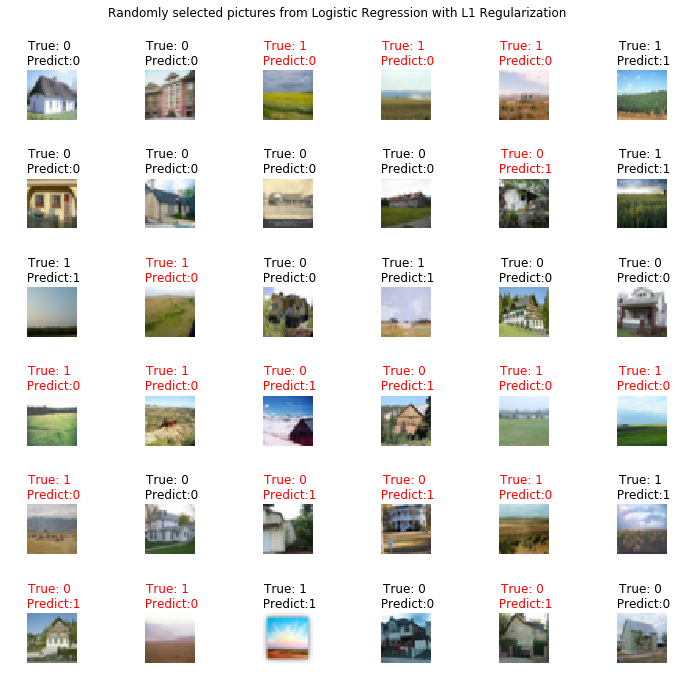

In [0]:
img_print(y_test, y_test_pred, 'Logistic Regression with L1 Regularization')

In [0]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(x_train_pca, y_train)
y_test_pred = clf.predict(x_test_pca)
print ("Adaboost train accuracy: {}%".format(clf.score(x_train_pca, y_train)*100))
print ("Adaboost test accuracy: {}%".format(clf.score(x_test_pca, y_test)*100))

Adaboost train accuracy: 74.41666666666666%
Adaboost test accuracy: 77.5%


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(x_train_pca, y_train)
y_test_pred = clf.predict(x_test_pca)
print ("Gradient train accuracy: {}%".format(clf.score(x_train_pca, y_train)*100))
print ("Gradient test accuracy: {}%".format(clf.score(x_test_pca, y_test)*100))

Gradient train accuracy: 84.20833333333333%
Gradient test accuracy: 82.08333333333333%


## Part 2: using Gray channel only
### Combined All features
1. gray pixels 
2. color ratio 
3. color saturation 
4. color gradient


### PCA

### Models:
1. Logistic Regression
2. GradientBoosting

### Results:
1. Logistic Regression: 66.23% train, 69.58% test
2. GradientBoosting: 83.33% train, 83.25% test

In [0]:
x_train_gray = pd.DataFrame(x_train_gray)
x_train_gray['saturation'] = x_train_sat
x_train_gray['colorRatio'] = x_train_percentage
x_train_gray = pd.concat([x_train_gray,x_train_df_grad], axis = 1)


x_test_gray = pd.DataFrame(x_test_gray)
x_test_gray['saturation'] = x_test_sat
x_test_gray['colorRatio'] = x_test_percentage
x_test_gray = pd.concat([x_test_gray,x_test_df_grad], axis = 1)

In [0]:
x_train_gray.shape, x_test_gray.shape

((4800, 4098), (1200, 4098))

In [0]:
pca = PCA(0.9)
x_train_gray_pca = pca.fit_transform(x_train_gray)
x_test_gray_pca = pca.transform(x_test_gray)

In [0]:
x_train_gray_pca.shape,x_test_gray_pca.shape

((4800, 127), (1200, 127))

In [0]:
logit = LogisticRegression(penalty = 'l1')
logit.fit(x_train_gray_pca, y_train)
y_test_pred = logit.predict(x_test_gray_pca)
print ("Logistic Regression with L1 Regulation train accuracy: {}%".format(logit.score(x_train_gray_pca, y_train)*100))
print ("Logistic Regression with L1 Regulation test accuracy: {}%".format(logit.score(x_test_gray_pca, y_test)*100))

Logistic Regression with L1 Regulation train accuracy: 66.22916666666666%
Logistic Regression with L1 Regulation test accuracy: 59.583333333333336%


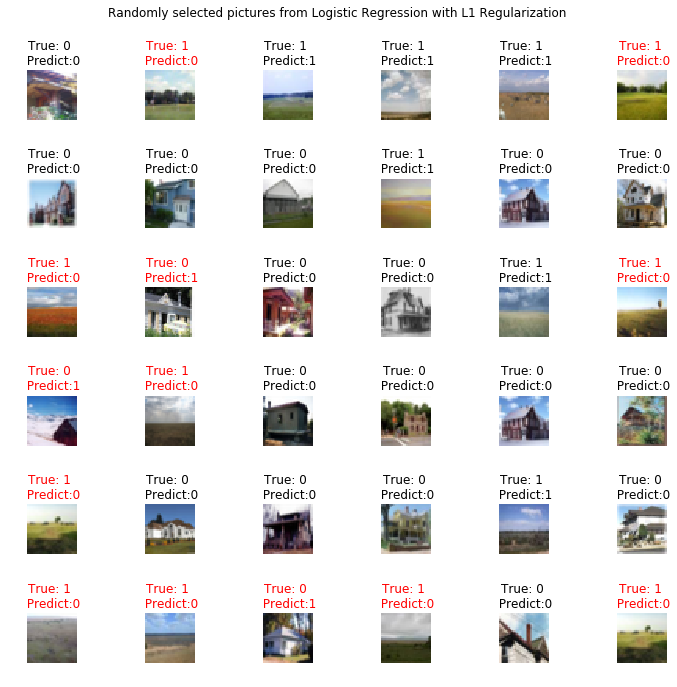

In [0]:
img_print(y_test, y_test_pred, 'Logistic Regression with L1 Regularization')

In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.58      0.68      0.63       600
         1.0       0.62      0.51      0.56       600

   micro avg       0.60      0.60      0.60      1200
   macro avg       0.60      0.60      0.59      1200
weighted avg       0.60      0.60      0.59      1200

        pred:0  pred:1
true:0     408     192
true:1     293     307


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(x_train_gray_pca, y_train)
y_test_pred = clf.predict(x_test_gray_pca)
print ("Gradient train accuracy: {}%".format(clf.score(x_train_gray_pca, y_train)*100))
print ("Gradient test accuracy: {}%".format(clf.score(x_test_gray_pca, y_test)*100))

Gradient train accuracy: 83.33333333333334%
Gradient test accuracy: 83.33333333333334%


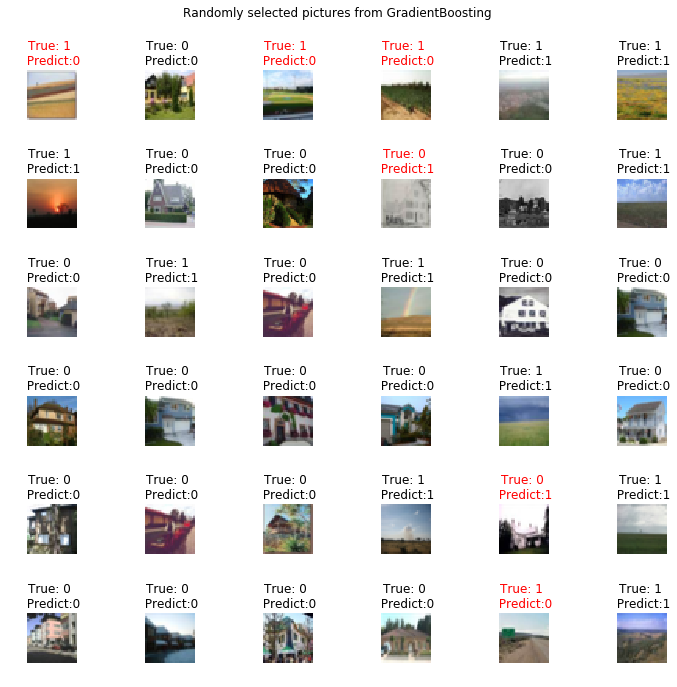

In [0]:
img_print(y_test, y_test_pred, 'GradientBoosting')

In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       600
         1.0       0.85      0.81      0.83       600

   micro avg       0.83      0.83      0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200

        pred:0  pred:1
true:0     517      83
true:1     117     483


## Part 3: using Color Histgram
### Combined All features
1. Color Histgram
2. color ratio 
3. color saturation 
4. color gradient


### PCA

### Models:
1. Logistic Regression
2. GradientBoosting


### Results:
1. Logistic Regression: 66.19% train, 59.58% test
2. GradientBoosting: 83.46% train, 83.25% test




In [0]:
x_train_hist = pd.DataFrame(x_train_hist)
x_train_hist['saturation'] = x_train_sat
x_train_hist['colorRatio'] = x_train_percentage
#x_train_df_grad = pd.DataFrame(x_train_grad)
x_train_hist = pd.concat([x_train_hist,x_train_df_grad], axis = 1)


x_test_hist = pd.DataFrame(x_test_hist)
x_test_hist['saturation'] = x_test_sat
x_test_hist['colorRatio'] = x_test_percentage
x_test_hist = pd.concat([x_test_hist,x_test_df_grad], axis = 1)

In [0]:
x_train_hist.shape

(4800, 35842)

In [0]:
# Decrease dimension 35842 to 
pca = PCA(0.9)
x_train_hist_pca = pca.fit_transform(x_train_hist)
x_test_hist_pca = pca.transform(x_test_hist)

In [0]:
x_train_hist_pca.shape

(4800, 127)

In [0]:
logit = LogisticRegression(penalty = 'l1')
logit.fit(x_train_hist_pca, y_train)
y_test_pred = logit.predict(x_test_hist_pca)
print ("Logistic Regression with L1 Regulation train accuracy: {}%".format(logit.score(x_train_hist_pca, y_train)*100))
print ("Logistic Regression with L1 Regulation test accuracy: {}%".format(logit.score(x_test_hist_pca, y_test)*100))

Logistic Regression with L1 Regulation train accuracy: 66.1875%
Logistic Regression with L1 Regulation test accuracy: 59.583333333333336%


In [0]:
clf2 = GradientBoostingClassifier()
clf2.fit(x_train_hist_pca, y_train)
y_test_pred = clf2.predict(x_test_hist_pca)
print ("Gradient train accuracy: {}%".format(clf2.score(x_train_hist_pca, y_train)*100))
print ("Gradient test accuracy: {}%".format(clf2.score(x_test_hist_pca, y_test)*100))

Gradient train accuracy: 83.45833333333333%
Gradient test accuracy: 83.41666666666666%


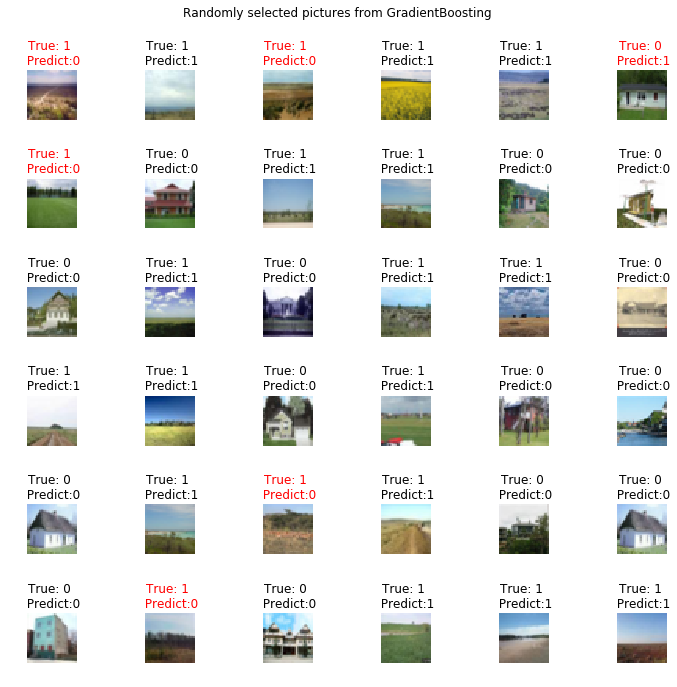

In [0]:
img_print(y_test, y_test_pred, 'GradientBoosting')

In [0]:
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       600
         1.0       0.86      0.79      0.83       600

   micro avg       0.83      0.83      0.83      1200
   macro avg       0.84      0.83      0.83      1200
weighted avg       0.84      0.83      0.83      1200

        pred:0  pred:1
true:0     525      75
true:1     124     476


## FNN

In [0]:
#Make y onehot encode
#y_train_nn = pd.get_dummies(pd.DataFrame(y_train))
#y_test_nn = pd.get_dummies(pd.DataFrame(y_test))

from keras.utils import to_categorical
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

In [0]:
def DefineModel():

    ################################################################
    # Activity 2 (Network Structure):
    # Group A: uses only 1 layer
    # second_layer_width = 0
    #
    # Group B: uses 2 layers of a tower-shaped (same width) network.
    # second_layer_width = 128
    #
    # Group C: uses 2 layers of a pyramid-shaped (shrink width) network.
    # second_layer_width = 64
    ################################################################
    first_layer_width = 128
    second_layer_width = 64  
    third_layer_width = 32
    fourth_layer_width = 16
    
    ################################################################
    # Activity 3 (Activation Function):
    # Group A uses ReLU.
    # activation_func = 'relu' 
    # 
    # Group B uses Sigmoid.
    # activation_func = 'sigmoid'
    #
    # Group C uses Tanh.
    # activation_func = 'tanh'
    ################################################################
    activation_func = 'relu' 

    ################################################################    
    # Activity 4 (Loss Function):
    # Group A uses cross entropy.
    # loss_function = 'categorical_crossentropy'
    # 
    # Group B uses cross entropy.
    # loss_function = 'categorical_crossentropy'
    # 
    # Group C uses squared error.
    # loss_function = 'mean_squared_error'
    ################################################################    
    loss_function = 'categorical_crossentropy'
    
    #################################################################    
    # Activity 5 (Dropout):
    # Group A uses 0% dropout.
    #
    # Group B uses 50% dropout.
    # dropout_rate = 0.5
    #
    # Group C uses 90% dropout.
    # dropout_rate = 0.9
    #################################################################    
    dropout_rate = 0.2
    
    ################################################################    
    # Activity 6 (Regularization):
    # Group A uses L1 regularizer
    # weight_regularizer = l1(0.01)
    #
    # Group B uses L2 regularizer
    # weight_regularizer = l2(0.01)
    # 
    # Group C uses no regularizer
    # weight_regularizer = None
    ################################################################
    weight_regularizer = l1(0.01)

    ################################################################    
    # Activity 8 (Learning Rate):
    # Group A uses learning rate of 0.1.
    # learning_rate = 0.1
    # 
    # Group B uses learning rate of 0.01.
    # learning_rate = 0.01
    #
    # Group C uses learning rate of 0.5.    
    # learning_rate = 0.5
    ################################################################
    learning_rate = 0.01
    
    ## Initialize model.
    model = Sequential()

    ## First hidden layer with 'first_layer_width' neurons. 
    ## Also need to specify input dimension.
    ## 'Dense' means fully-connected.
    model.add(Dense(first_layer_width, input_dim=127, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    if dropout_rate > 0:
        model.add(Dropout(0.1))

    ## Second hidden layer.
    if second_layer_width > 0:
        model.add(Dense(second_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(0.2))         

    ## Third hidden layer.
    if third_layer_width > 0:
        model.add(Dense(third_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(0.2))      

    ## Fourth hidden layer.
    if fourth_layer_width > 0:
        model.add(Dense(fourth_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(0.2))  
            
            
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(2))
    
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    ## Define optimizer. In this tutorial/codelab, we select SGD.
    ## You can also use other methods, e.g., opt = RMSprop()
    opt = SGD(lr=learning_rate, clipnorm=5.)
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

    return model

In [0]:
def TrainModel(data=None,epochs=500):
    ################################################################
    # Activity 7 (Mini-batch):
    # Group A uses mini-batch of size 128.
    # batch = 128
    #
    # Group B uses mini-batch of size 256.
    # batch = 256
    # 
    # Group C uses mini-batch of size 512.
    # batch = 512
    ################################################################
    batch=128
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print("Must provide data.")
        return
    x_train, x_test, y_train, y_test = data
    print('Start training.')
    ## Use the first 55,000 (out of 60,000) samples to train, last 5,500 samples to validate.
    #history = model.fit(x_train[:4320], y_train[:4320], nb_epoch=epochs, batch_size=batch,
    #          validation_data=(x_train[4320:], y_train[4320:]))
    history = model.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch)
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

In [0]:
trained_model, training_history = TrainModel(data=[x_train_gray_pca, x_test_gray_pca, y_train_nn, y_test_nn])

Start training.
Epoch 1/500
4800/4800 [==============================] - 2s 430us/step - loss: 16.8144 - acc: 0.5081
Epoch 2/500
4800/4800 [==============================] - 0s 30us/step - loss: 13.6045 - acc: 0.5125
Epoch 3/500
4800/4800 [==============================] - 0s 30us/step - loss: 12.6096 - acc: 0.5110
Epoch 4/500
4800/4800 [==============================] - 0s 32us/step - loss: 12.0133 - acc: 0.5167
Epoch 5/500
4800/4800 [==============================] - 0s 34us/step - loss: 11.4062 - acc: 0.5269
Epoch 6/500
4800/4800 [==============================] - 0s 30us/step - loss: 10.8147 - acc: 0.5450
Epoch 7/500
4800/4800 [==============================] - 0s 32us/step - loss: 10.2619 - acc: 0.5373
Epoch 8/500
4800/4800 [==============================] - 0s 30us/step - loss: 9.7194 - acc: 0.5473
Epoch 9/500
4800/4800 [==============================] - 0s 30us/step - loss: 9.1772 - acc: 0.5727
Epoch 10/500
4800/4800 [==============================] - 0s 31us/step - loss: 8.6735

In [0]:
def TestModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

In [0]:
test_score = TestModel(model=trained_model, data=[x_test_gray_pca, y_test_nn])
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

1200/1200 [==============================] - 1s 599us/step
Test loss 0.9909, accuracy 68.42%
